# Modelo: Stacking

El modelo a entrenar en el sigueinte notebook será Stacking: un ensamble hiíbrido que combina distintos clasificadores de distinto tipo. Se trata de entrenar diferentes modelos (modelos base) y por ultimo, un modelo más, que decide, dada una instancia nueva, qué modelo usar. 

# Librerias y funciones necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing, tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn import preprocessing, tree
from sklearn.linear_model import LogisticRegression
from preprocessing import get_dataframe_scaled
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn import preprocessing, tree
from sklearn.svm import LinearSVC

In [2]:
from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica
from preprocessing import plot_roc_curves
from preprocessing import graficar_matriz_confusion
from preprocessing import aplicar_preparacion_generalizado
from preprocessing import conversion_numerica_generalizada
from preprocessing import get_dataframe_scaled
from preprocessing import reduccion_rfecv
from preprocessing import get_dataframe_polynomial
from preprocessing import aplicar_preparacion
from preprocessing import conversion_numerica

# Modelos a utilizar 

Se eligiran los siguientes modelos, con sus hiperparámetros encontrados en otros notebooks para aplicar Stacking:
* KNN
* SVM (con el kernel lineal)
* Decision Tree

Como modelo estimador final se elegirá el mejor de alguno de estos:
* Perceptron
* Regresión Logistica (es la default de StackingClassifier en sklearn)
* KNN
* Decision Tree

Cabe aclarar que para el estimador final no le estableceremos hiperpárametros, al StackingClassifier le daremos un clasificador como tal con parametros por default (de la misma forma que utiliza la Logistic Regresion con hiperparámetros por default) y que mediante GridSearchCV buscamos cual estimador fue el mejor para para predecir.

Importemos el dataset a utilizar:

In [3]:
df, df_for_prediction = obtener_datasets()

# Primer Preprocesamiento

En este primer preprocesamietno aplicaremos un escalado **MinMaxScaler()** de los datos con ayuda de nuestra funcion importada **get_dataframe_scaled()**. Primero apliquemos la preparacion que venimos aplicando como en otros modelos y luego la conversión numérica.

In [4]:
X_df, y_df = aplicar_preparacion(df)

In [5]:
X_df_numerico = conversion_numerica(X_df) 
X_df_numerico.shape

Aplicando 'conversion_numerica' en las variables categóricas.


(32561, 40)

Dividamos este set numerico en train y test. Luego escalemos (para evitar leaks) los datos tal como lo habiamos mencionado en este preprocesamiento:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, MinMaxScaler(feature_range=(-1,1)))
X_test = get_dataframe_scaled(X_test, MinMaxScaler(feature_range=(-1,1)))

## Entrenamiento

Definamos los 3 clasificadores mencionados, con sus respectivos **mejores hiperparámetros** para el preprocesado de datos aplicado, encontrados en otros notebook

In [7]:
clf_1 = KNeighborsClassifier(n_neighbors =35, weights = 'uniform')
clf_2 = LinearSVC( random_state=10,verbose=True, dual=False, C=75, loss='squared_hinge', penalty = 'l2')
clf_3 = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 7, min_samples_leaf = 50, random_state=10)

Definimos el modelo Stacking con estos 3 clasificadores y definimos tambien para utilizar con GridSearchCV los 4 distintos estimadores finales:

In [8]:
stacking_model = StackingClassifier(estimators=[('clf_1', clf_1), ('clf_2', clf_2),  ('clf_3', clf_3)])
params = [{'final_estimator':
           [LogisticRegression(random_state=10), 
            KNeighborsClassifier(),
            tree.DecisionTreeClassifier(random_state=10),  
            Perceptron(random_state=10)]}]

Entrenemos:

In [9]:
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_stacking_1 = GridSearchCV(stacking_model, 
                   param_grid = params,
                   scoring = 'roc_auc',
                   cv = cv_e,
                   n_jobs = -1,
                   verbose=1)

clf_stacking_1.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  4.9min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fe753f56580>,
             estimator=StackingClassifier(estimators=[('clf_1',
                                                       KNeighborsClassifier(n_neighbors=35)),
                                                      ('clf_2',
                                                       LinearSVC(C=75,
                                                                 dual=False,
                                                                 random_state=10,
                                                                 verbose=True)),
                                                      ('clf_3',
                                                       DecisionTreeClassifier(max_depth=7,
                                                                              min_samples_leaf=50,
                                                                              random_state=10))]),
             n_jobs=-1,
             param_

## Métricas

Con este stacking evaluamos con X_test. Tambien obtengamos la probabilidad predecida para cada clase:

In [10]:
y_pred = clf_stacking_1.predict(X_test)
y_pred_proba = clf_stacking_1.predict_proba(X_test)[:, 1]

Veamos diferentes métricas:

AUC-ROC score sobre test:  0.9055711680526609
AUC-ROC score sobre train:  0.9170179423665286
Accuracy sobre test:  0.8509135575003839
Los mejores hiperpametros elegidos:  {'final_estimator': LogisticRegression(random_state=10)}
              precision    recall  f1-score   support

  Bajo valor       0.87      0.94      0.91      4945
  Alto valor       0.76      0.56      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.81      0.75      0.77      6513
weighted avg       0.84      0.85      0.84      6513



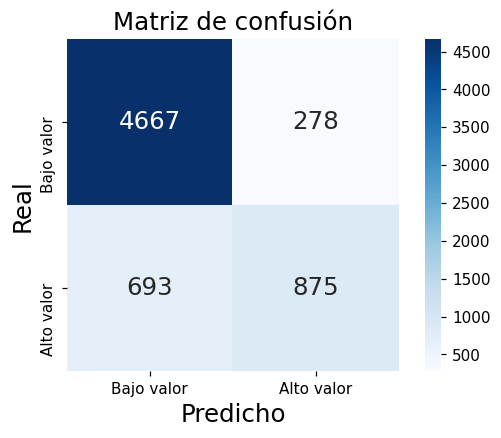

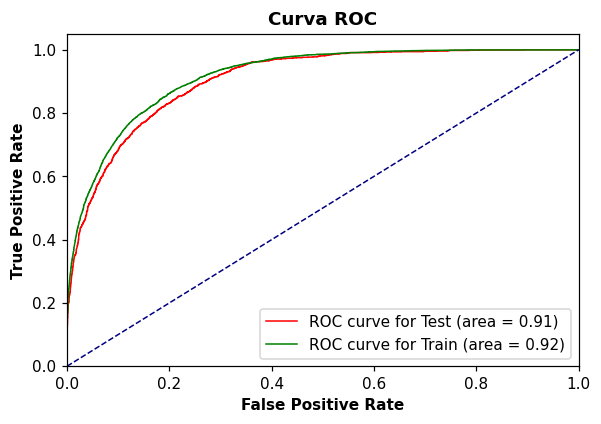

In [11]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, y_pred_proba))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_stacking_1.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf_stacking_1.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_stacking_1, X_test, y_test, X_train, y_train)

Vemos que tiene buen score comparado con haber realizado los 3 modelos clasificadores individualmente en sus respectivos notebooks. Además, se nota una mejora en la precision de las instancias con altos valores. Veamos si con un segundo preprocesamiento esto mejora.

# Segundo Preprocesamiento

Veamos con un segundo preprocesado de los datos si mejoramos o no este score de AUC-ROC. Con los 3 clasificadores presentados, en otros notebooks hemos trabajado con este otro escalado y vimos que en algunos mejoró y otros no, pero en general con esos escalados el score conseguido individualmente no alcanzaba al encontrado en el primero preprocesamiento. Veamos ahora con este segundo preprocesamiento que tal nos va:

## Entrenamiento

In [12]:
X_df_numerico.shape

(32561, 40)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_df_numerico, y_df, test_size=0.20, random_state=10, stratify=y_df)
X_train = get_dataframe_scaled(X_train, StandardScaler())
X_test = get_dataframe_scaled(X_test, StandardScaler())

Para este preprocesamiento, segun lo investigado entonces en otros notebooks, los mejores hiperparametros a elegir seran:

In [14]:
clf_1 = KNeighborsClassifier(n_neighbors =40, weights = 'uniform')
clf_2 = LinearSVC( random_state=10,verbose=True, dual=False, C=71, loss='squared_hinge', penalty = 'l1')
clf_3 = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 7, min_samples_leaf = 50, random_state=10)

In [15]:
stacking_model = StackingClassifier(estimators=[('clf_1', clf_1), ('clf_2', clf_2),  ('clf_3', clf_3)])
params = [{'final_estimator':
           [LogisticRegression(random_state=10), 
            KNeighborsClassifier(),
            tree.DecisionTreeClassifier(random_state=10),  
            Perceptron(random_state=10)]}]

Entrenamos

In [16]:
cv_e = StratifiedKFold(n_splits=5,random_state=10, shuffle=True).split(X_train, y_train)
clf_stacking_2 = GridSearchCV(stacking_model, 
                   param_grid = params,
                   scoring = 'roc_auc',
                   cv = cv_e,
                   n_jobs = -1,
                   verbose=1)

clf_stacking_2.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.4min finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fe768227f20>,
             estimator=StackingClassifier(estimators=[('clf_1',
                                                       KNeighborsClassifier(n_neighbors=40)),
                                                      ('clf_2',
                                                       LinearSVC(C=71,
                                                                 dual=False,
                                                                 penalty='l1',
                                                                 random_state=10,
                                                                 verbose=True)),
                                                      ('clf_3',
                                                       DecisionTreeClassifier(max_depth=7,
                                                                              min_samples_leaf=50,
                                                               

## Métricas

In [17]:
y_pred = clf_stacking_2.predict(X_test)
y_pred_proba = clf_stacking_2.predict_proba(X_test)[:, 1]

AUC-ROC score sobre test:  0.9062014429128576
AUC-ROC score sobre train:  0.9167829779584329
Accuracy sobre test:  0.8512206356517734
Los mejores hiperpametros elegidos:  {'final_estimator': LogisticRegression(random_state=10)}
              precision    recall  f1-score   support

  Bajo valor       0.87      0.94      0.91      4945
  Alto valor       0.76      0.56      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.82      0.75      0.78      6513
weighted avg       0.84      0.85      0.84      6513



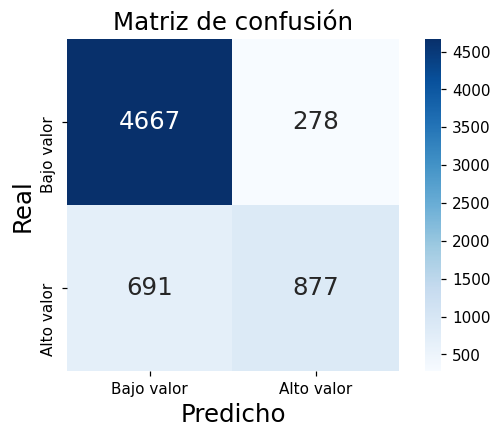

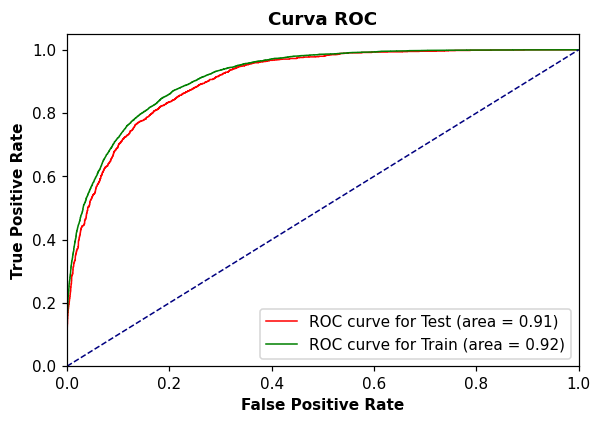

In [18]:
print("AUC-ROC score sobre test: ", "%0.16f"  % roc_auc_score(y_test, y_pred_proba))
print("AUC-ROC score sobre train: ", "%0.16f"  % roc_auc_score(y_train, clf_stacking_2.predict_proba(X_train)[:, 1]))
print("Accuracy sobre test: ", "%0.16f"  % accuracy_score(y_pred, y_test))
print("Los mejores hiperpametros elegidos: ", clf_stacking_2.best_params_)
print(classification_report(y_test, y_pred, target_names=["Bajo valor", "Alto valor"]))
graficar_matriz_confusion(y_test, y_pred)
plot_roc_curves(clf_stacking_2, X_test, y_test, X_train, y_train)

Vemos que una mejora poca significativa en el AUC-ROC como tambien en la accuracy. Nos quedamos este como mejor preprocesado a los datos.

# Holdout